In [106]:
#primarily from
#https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346
#https://github.com/Carterbouley/ElectricityPricePrediction/blob/master/multivariate_LSTM_electricity.ipynb

In [107]:
import sys
!{sys.executable} -m pip install Rpy2 pandas yfinance sklearn matplotlib statsmodels yahoofinancials

distutils: /mnt/distvol/Python-3.9.4/include/python3.9/UNKNOWN
sysconfig: /mnt/distvol/Python-3.9.4/include/python3.9
user = False
home = None
root = None
prefix = None
distutils: /mnt/distvol/Python-3.9.4/include/python3.9/UNKNOWN
sysconfig: /mnt/distvol/Python-3.9.4/include/python3.9
user = False
home = None
root = None
prefix = None


In [108]:
import pandas as pd
import yfinance as yf
import numpy as np
import os
os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'
import rpy2.robjects as R
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from yahoofinancials import YahooFinancials
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm

tsize = 0.30

Stock = yf.download('GOLD', 
                      start='2013-01-01', 
                      end='2019-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 

all_data = Stock[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

#all_data = all_data.filter(['GBP/mWh','temperature','coal Price','oil Price','uranium Price','natural gas Price'])

#all_data['return'] = all_data['Adj Close'].pct_change()

#all_data = all_data.filter(['return','Adj Close','Open','High','Low','Close','Volume']).dropna()
#all_data[23:47]
#all_data['Adj Close'].plot()
# There are 1,510 and 251 observations in the training and test data respectively.

In [109]:
all_data = pd.read_csv('/mnt/distvol/re_fixed_multivariate_timeseries.csv').set_index('datetime')

from datetime import datetime
all_data.index = pd.to_datetime(all_data.index)
#all_data.resample('D')

all_data = all_data.resample('D').mean().dropna()


In [110]:
R.r('''
           f <- function(values) {
                    #system("which openssl")

                    library(snpEnrichment)
                    library(arfima)
                    library(parallel)
                    library(forecast)                    
                    
                    dset <- mclapply(1:ncol(values),function(x)
                    {
                        column = values[,x]
                        
                        
                        #tryCatch(invisible(capture.output(suppressMessages(suppressWarnings(
                        #{
                          varvefd = arfima(column)
                          d = summary(varvefd)$coef[[1]][1]
                          return(d)
                        #}
                       #)
                       #))),
                        #error=function(e)
                          #{
                            #d = 1
                            #return(d)
                          #})
                    
                    })    
                    
                    unlist(dset)

            }
            ''')

r_f = R.globalenv['f']
d=R.conversion.rpy2py((r_f(R.conversion.py2rpy(all_data.dropna()))))


In [111]:
from __future__ import division

import numpy as np
from scipy import linalg

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, as_float_array

class ZCA(BaseEstimator, TransformerMixin):
    def __init__(self, regularization=1e-6, copy=False):
        self.regularization = regularization
        self.copy = copy

    def fit(self, X, y=None):
        """Compute the mean, whitening and dewhitening matrices.
        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data used to compute the mean, whitening and dewhitening
            matrices.
        """
        X = check_array(X, accept_sparse=None, copy=self.copy,
                        ensure_2d=True)
        X = as_float_array(X, copy=self.copy)
        self.mean_ = X.mean(axis=0)
        X_ = X - self.mean_
        cov = np.dot(X_.T, X_) / (X_.shape[0]-1)
        U, S, _ = linalg.svd(cov)
        s = np.sqrt(S.clip(self.regularization))
        s_inv = np.diag(1./s)
        s = np.diag(s)
        self.whiten_ = np.dot(np.dot(U, s_inv), U.T)
        self.dewhiten_ = np.dot(np.dot(U, s), U.T)
        return self

    def transform(self, X, y=None, copy=None):
        """Perform ZCA whitening
        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to whiten along the features axis.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X - self.mean_, self.whiten_.T)

    def inverse_transform(self, X, copy=None):
        """Undo the ZCA transform and rotate back to the original
        representation
        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to rotate back.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X, self.dewhiten_) + self.mean_

In [192]:
def ts_train_test_normalize(data,time_steps,for_periods, n_features):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set

    #n_features = 1

    #data=Lagged_Set

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import QuantileTransformer
    from sklearn.model_selection import train_test_split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    trainOuter, test = train_test_split(data, test_size=tsize, shuffle=False)

    #from zca import ZCA
    trf = ZCA().fit(trainOuter.iloc[:,1:])
    #trainOuter_whitened = trf.transform(trainOuter.iloc[:,1:])

    #X_reconstructed = trf.inverse_transform(X_whitened)
    #assert(np.allclose(X, X_reconstructed)) # True
    #X=pd.DataFrame(X_whitened).set_index(Y.index)

    trainInner, valid = train_test_split(trainOuter, test_size=0.15, shuffle=False)
    trainInner_whitened = pd.DataFrame(trf.transform(trainInner.iloc[:,1:])).set_index(trainInner.index)
    valid_whitened = pd.DataFrame(trf.transform(valid.iloc[:,1:])).set_index(valid.index)
    test_whitened = pd.DataFrame(trf.transform(test.iloc[:,1:])).set_index(test.index)

    trainOuter_whitened=pd.DataFrame(trf.transform(trainOuter.iloc[:,1:])).set_index(trainOuter.index)

    #add y
    std = np.std(trainOuter.iloc[:,0])
    mean = np.mean(trainOuter.iloc[:,0])
    trainInner = pd.concat([(trainInner.iloc[:,0]-mean)/std,trainInner_whitened],axis=1)
    trainInner.columns = data.columns
    valid = pd.concat([(valid.iloc[:,0]-mean)/std,valid_whitened],axis=1)
    valid.columns = data.columns
    test = pd.concat([(test.iloc[:,0]-mean)/std,test_whitened],axis=1)
    test.columns = data.columns

    trainOuter = pd.concat([(trainOuter.iloc[:,0]-mean)/std,trainOuter_whitened],axis=1)

    #sc = MinMaxScaler()
    #sc = RobustScaler()
    #sc = Normalizer()
    #sc = QuantileTransformer(output_distribution='normal',n_quantiles=10)
    sc = StandardScaler()

    #transform each range to scale

    #sc.fit(data[(data.index<'2019')].iloc[:,0:n_features])
    sc.fit(trainOuter)

    #transform each range to scale

    #s_train_scaled = data[(data.index<'2017')].iloc[:,0:n_features].values
    #ts_train_scaled = sc.transform(data[(data.index<='2017')].iloc[:,0:n_features])    
    #ts_train_scaled = sc.transform(trainInner)    
    ts_train_scaled = trainInner
    #ts_valid_scaled = data[(data.index>='2017')&(data.index<'2019')].iloc[:,0:n_features].values
    #ts_valid_scaled = sc.transform(data[(data.index>'2017')&(data.index<'2019')].iloc[:,0:n_features])
    #ts_valid_scaled = sc.transform(valid)
    ts_valid_scaled = valid
    #ts_test_scaled  = data[(data.index>='2019')].iloc[:,0:n_features].values
    #ts_test_scaled  = sc.transform(data[(data.index>='2019')].iloc[:,0:n_features])
    #ts_test_scaled  = sc.transform(test)
    ts_test_scaled  = test

    #new_series = pd.DataFrame(data[:'2017'].iloc[:,0:n_features].values).append(pd.DataFrame(data['2017':'2018'].iloc[:,0:n_features].values),ignore_index=True).append(pd.DataFrame(data['2019':].iloc[:,0:n_features].values),ignore_index=True)
    new_series = pd.DataFrame(ts_train_scaled).append(pd.DataFrame(ts_valid_scaled)).append(pd.DataFrame(ts_test_scaled))

    series_reshaped = np.array([new_series[i:i + (n_steps+n_ahead)].copy() for i in range(len(data) - (n_steps+n_ahead))])        

    X_train = series_reshaped[:len(ts_train_scaled)-(n_steps+n_ahead)+2,:n_steps]
    X_valid = series_reshaped[len(ts_train_scaled)-(n_steps+n_ahead)+2:len(ts_train_scaled)-(n_steps+n_ahead)+2+len(ts_valid_scaled),:n_steps]
    X_test = series_reshaped[-len(ts_test_scaled)+2:,:n_steps]

    Y = np.empty(((len(data) - n_steps - n_ahead), n_steps, n_ahead))  

    for step_ahead in range(1, n_ahead + 1):     
       Y[..., step_ahead - 1] =   series_reshaped[..., step_ahead:step_ahead + n_steps, 0]

    Y_train = Y[:len(ts_train_scaled)-(n_steps+n_ahead)+2,:n_steps]
    Y_valid = Y[len(ts_train_scaled)-(n_steps+n_ahead)+2:len(ts_train_scaled)-(n_steps+n_ahead)+2+len(ts_valid_scaled),:n_steps]
    Y_test = Y[-len(ts_test_scaled)+2:,:n_steps]

    #inverse
    #test
    
    #Y
    #pd.DataFrame(test).iloc[:,0]*std+mean
    #pd.DataFrame((sc.inverse_transform(ts_test_scaled))).iloc[:,0]*std+mean
    
    #X
    #pd.DataFrame(trf.inverse_transform(pd.DataFrame((sc.inverse_transform(ts_test_scaled))).iloc[:,1:]))
    #pd.DataFrame(trf.inverse_transform(pd.DataFrame(test).iloc[:,1:]))
    #rescaled = pd.concat([pd.DataFrame((sc.inverse_transform(ts_test_scaled))).iloc[:,0]*std+mean,pd.DataFrame(trf.inverse_transform(pd.DataFrame((sc.inverse_transform(ts_test_scaled))).iloc[:,1:]))],axis=1)
    #rescaled.columns = test.columns
    #rescaled.set_index(test.index)
    
    '''
    plt.hist(data[-len(test):].iloc[:,1], bins='auto')  # arguments are passed to np.histogram
    plt.show()
    plt.scatter(Lagged_Set[-len(test):].iloc[:,1], pd.DataFrame(pd.DataFrame(test).iloc[:,1]))
    plt.show()
    plt.scatter(Lagged_Set[-len(test):].iloc[:,1], pd.DataFrame(pd.DataFrame(ts_test_scaled).iloc[:,1]))
    plt.show()
    plt.scatter(pd.DataFrame(test).iloc[:,1], pd.DataFrame(pd.DataFrame(ts_test_scaled).iloc[:,1]))
    plt.show()
    '''

    #print(ts_train_scaled)
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, sc, trf, std, mean

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

def return_actual(model, sc, data_, X_test, trf, std, mean):

    Y_pred = (model.predict(X_test))    

    last_list=[]

    for i in range (0, len(Y_pred)):
      last_list.append((Y_pred[i][0][n_ahead-1]))

    last_list
    #actual = pd.DataFrame((sc.inverse_transform(X_test[:,0])))
    actual = pd.DataFrame(X_test[:,0])

    #actual = pd.DataFrame(((X_test[:,0])))
    actual.rename(columns = {0:'actual'}, inplace = True)
    actual["actual"]=actual["actual"]*std+mean
    actual.iloc[:,1:] = trf.inverse_transform(actual.iloc[:,1:])

    actual['predictions'] = last_list
    #last_list
    #actual['predictions'] = (invTransform(sc,actual["predictions"],data_.columns[0],data_.columns))
    actual['predictions'] = actual['predictions']*std+mean

    actual['difference'] = (actual['predictions'] - actual['actual']).abs()
    actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
    
    return(actual)

# - scaler   = the scaler object (it needs an inverse_transform method)
# - data     = the data to be inverse transformed as a Series, ndarray, ... 
#              (a 1d object you can assign to a df column)
# - ftName   = the name of the column to which the data belongs
# - colNames = all column names of the data on which scaler was fit 
#              (necessary because scaler will only accept a df of the same shape as the one it was fit on)
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values


In [113]:
def get_weights(d, num_k):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
    """
    w_k = np.array([1])
    
    for k in range(1, num_k):
        w_k = np.append(w_k, -w_k[-1] * ((d - k + 1)) / k)
        
    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def get_weights_floored(d, num_k, floor=1e-3):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$ provided weight above a minimum value
    (floor) for the weights to prevent computation of weights for the entire
    time series.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
        floor (float): minimum value for the weights for computational efficiency.
    """
    w_k = np.array([1])
    k = 1
    
    while k < num_k:
        w_k_latest = -w_k[-1] * ((d - k + 1)) / k
        if abs(w_k_latest) <= floor:
            break

        w_k = np.append(w_k, w_k_latest)
        
        k += 1

    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def frac_diff(df, d, floor=1e-3):
    r"""Fractionally difference time series via CPU.
    
    Args:
        df (pd.DataFrame): dataframe of raw time series values.
        d (float): differencing value from 0 to 1 where > 1 has no FD.
        floor (float): minimum value of weights, ignoring anything smaller.
    """
    # Get weights window
    weights = get_weights_floored(d=d, num_k=len(df), floor=floor)
    weights_window_size = len(weights)
    
    # Reverse weights
    weights = weights[::-1]
    
    # Blank fractionally differenced series to be filled
    df_fd = []

    # Slide window of time series, to calculated fractionally differenced values
    # per window
    for idx in range(weights_window_size, df.shape[0]):
        # Dot product of weights and original values
        # to get fractionally differenced values
        date_idx = df.index[idx]
        df_fd.append(np.dot(weights.T, df.iloc[idx - weights_window_size:idx]).item())
    
    # Return FD values and weights
    df_fd = pd.DataFrame(df_fd)
    
    return df_fd, weights

In [114]:

from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
trainOuter, test = train_test_split(all_data, test_size=tsize, shuffle=False)
#trainInner, valid = train_test_split(trainOuter, test_size=0.15, shuffle=False)


In [185]:

import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED
from fracdiff import fdiff

cores = int(len(os.sched_getaffinity(0)))

def getDifferenced(i):
    #v = d[[i]]
    #gquant_gpu, weights = frac_diff(all_data.iloc[:, i], d=d[[i]], floor=5e-5)
    
    a = np.array(trainOuter.iloc[:, i])
    
    return fdiff(a, n=d[i], axis=0)
    #gquant_gpu, weights = frac_diff(all_data.iloc[:, i]), d=v, floor=5e-5)

pool01 = concurrent.futures.ProcessPoolExecutor(cores)

futures01 = [pool01.submit(getDifferenced, args) for args in range(0,len(d))]

wait(futures01, timeout=None, return_when=ALL_COMPLETED)


DoneAndNotDoneFutures(done={<Future at 0x7fa64cf8ee50 state=finished returned ndarray>, <Future at 0x7fa64eb2ba90 state=finished returned ndarray>, <Future at 0x7fa64e5b7f10 state=finished returned ndarray>, <Future at 0x7fa64eb2b190 state=finished returned ndarray>, <Future at 0x7fa64eb2b3a0 state=finished returned ndarray>, <Future at 0x7fa64eb2b7c0 state=finished returned ndarray>}, not_done=set())

In [116]:
all_data.describe()

,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price
count,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000
mean,45.544870,53.469054,75.892142,71.081418,29.704445,3.114865
std,9.336876,9.938309,15.891444,23.745737,6.718934,0.725076
min,26.495000,25.803750,39.948750,27.937083,17.760417,1.640125
25%,39.188452,46.010833,64.252500,52.367500,24.450000,2.660000
50%,44.075208,53.121875,77.750000,63.655000,28.300000,2.939000
75%,50.285938,61.262813,87.508750,93.633438,35.750000,3.587219
max,170.150000,85.722083,111.160000,118.900000,44.000000,6.149000


In [186]:

Differenced_Set = pd.DataFrame()
for f in range(0,len(futures01)):
    value = pd.DataFrame(futures01[f].result())
    Differenced_Set = pd.concat([Differenced_Set,value],axis=1)
    
Differenced_Set.columns = all_data.columns

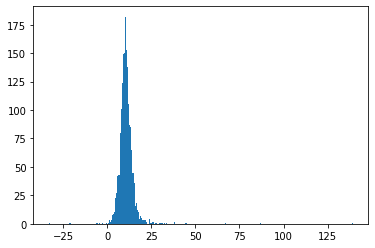

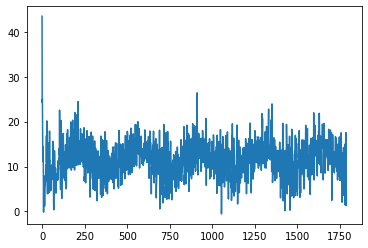

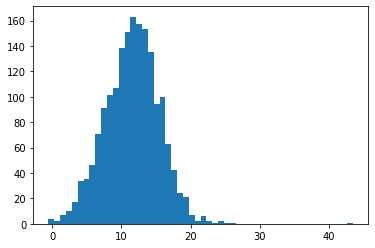

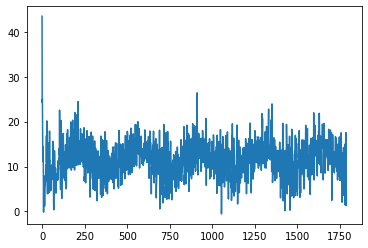

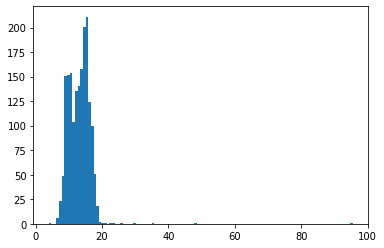

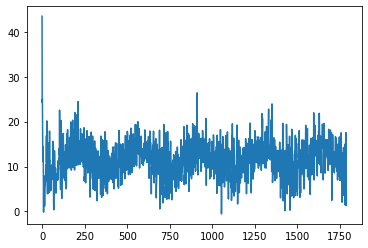

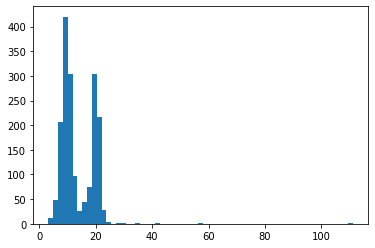

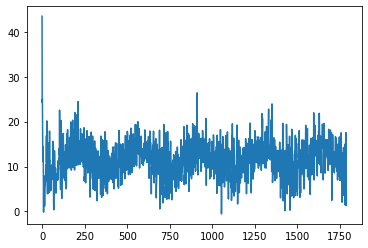

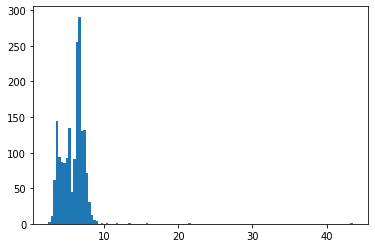

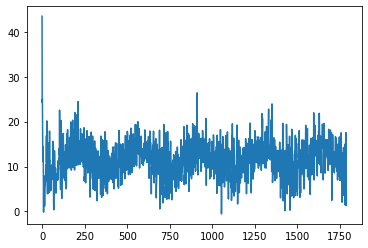

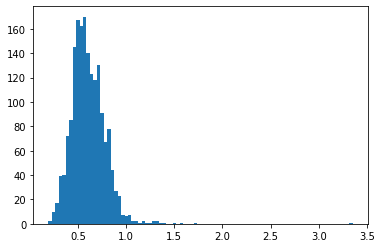

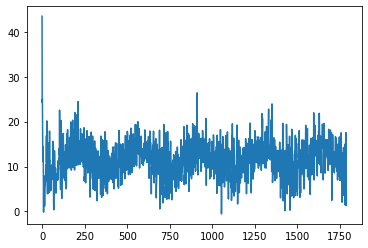

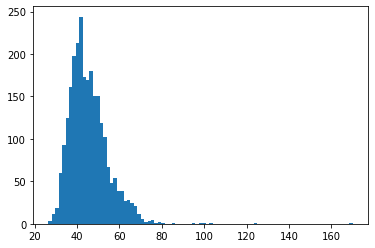

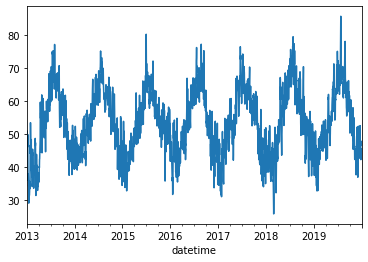

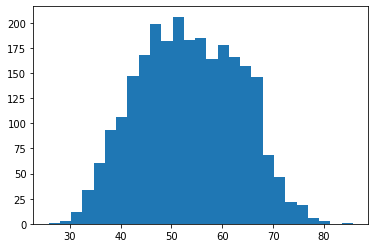

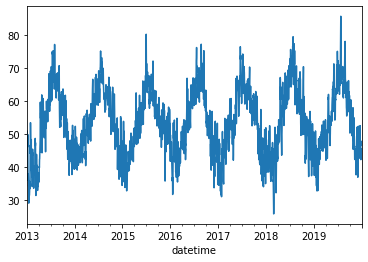

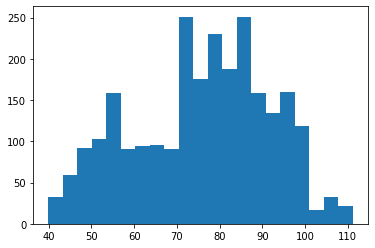

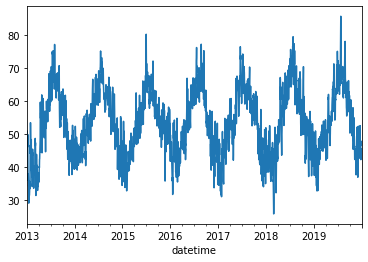

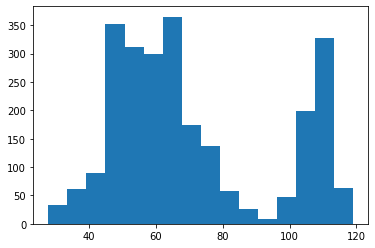

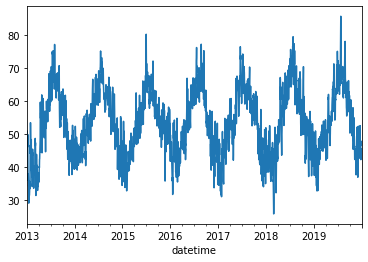

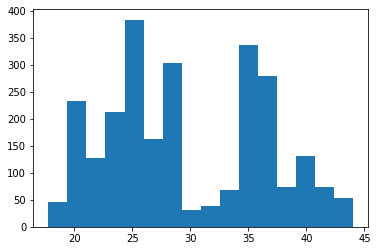

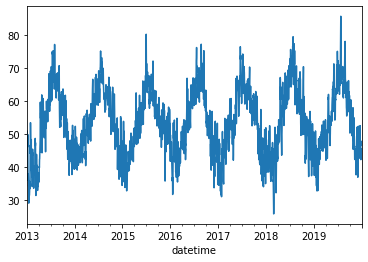

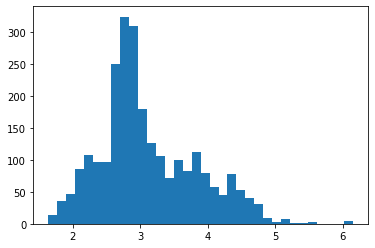

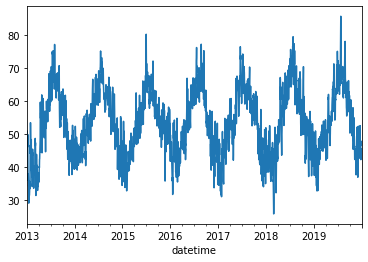

In [118]:

for f in range(0,len(futures01)):
    #print(f)
    #print(len(futures01[f].result()))
    plt.hist(Differenced_Set.iloc[:,f], bins='auto')  # arguments are passed to np.histogram
    plt.show()
    Differenced_Set.iloc[:,1].plot()
    plt.show()
    
for f in range(0,len(all_data.columns)):
    #print(f)
    #print(len(futures01[f].result()))
    plt.hist(all_data.iloc[:,f], bins='auto')  # arguments are passed to np.histogram
    plt.show()
    all_data.iloc[:,1].plot()
    plt.show()

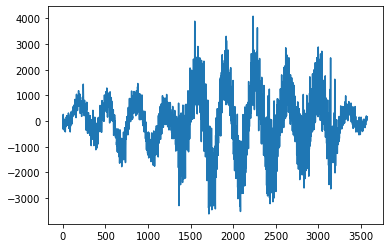

446


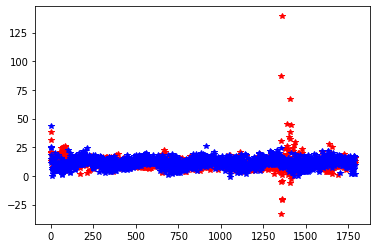

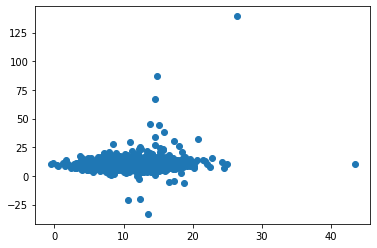

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


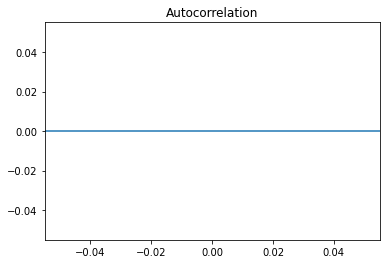

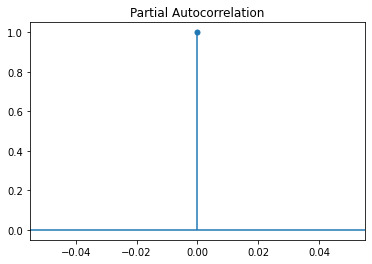

                                 OLS Regression Results                                
Dep. Variable:                GBP/mWh   R-squared (uncentered):                   0.691
Model:                            OLS   Adj. R-squared (uncentered):              0.691
Method:                 Least Squares   F-statistic:                              3997.
Date:                Thu, 29 Apr 2021   Prob (F-statistic):                        0.00
Time:                        22:18:13   Log-Likelihood:                         -5960.2
No. Observations:                1789   AIC:                                  1.192e+04
Df Residuals:                    1788   BIC:                                  1.193e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

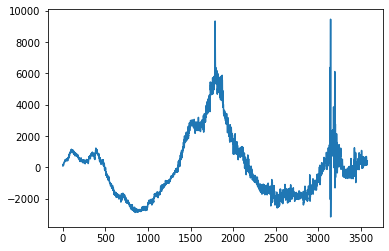

1357


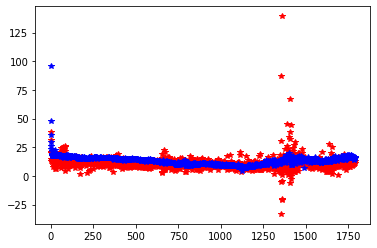

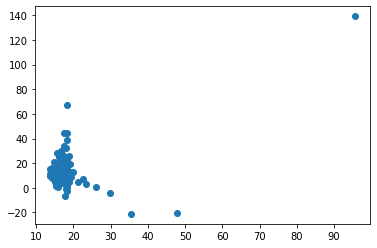

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


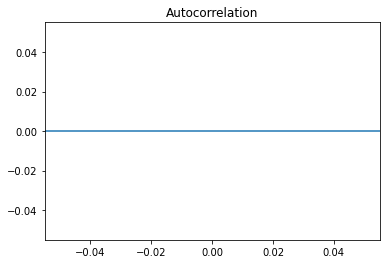

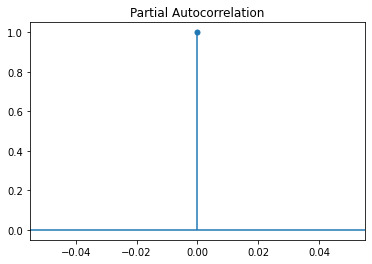

                                 OLS Regression Results                                
Dep. Variable:                GBP/mWh   R-squared (uncentered):                   0.792
Model:                            OLS   Adj. R-squared (uncentered):              0.792
Method:                 Least Squares   F-statistic:                              6814.
Date:                Thu, 29 Apr 2021   Prob (F-statistic):                        0.00
Time:                        22:18:14   Log-Likelihood:                         -5605.5
No. Observations:                1789   AIC:                                  1.121e+04
Df Residuals:                    1788   BIC:                                  1.122e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

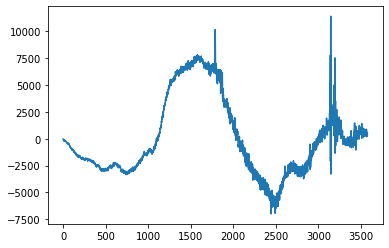

1357


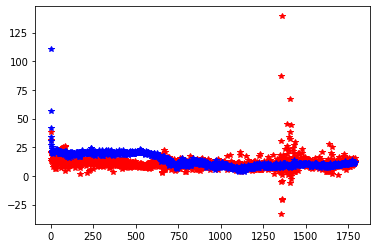

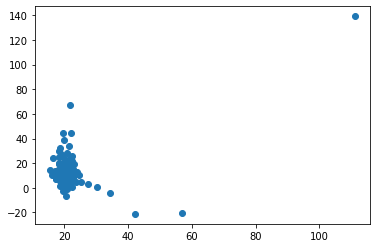

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


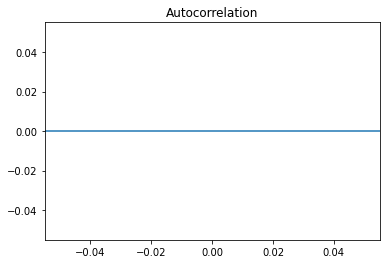

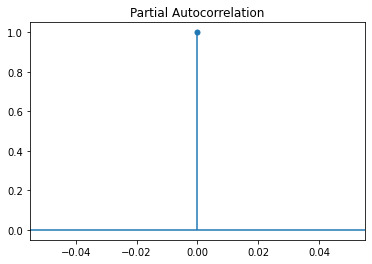

                                 OLS Regression Results                                
Dep. Variable:                GBP/mWh   R-squared (uncentered):                   0.718
Model:                            OLS   Adj. R-squared (uncentered):              0.718
Method:                 Least Squares   F-statistic:                              4548.
Date:                Thu, 29 Apr 2021   Prob (F-statistic):                        0.00
Time:                        22:18:15   Log-Likelihood:                         -5878.9
No. Observations:                1789   AIC:                                  1.176e+04
Df Residuals:                    1788   BIC:                                  1.177e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

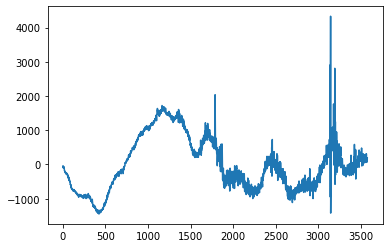

1357


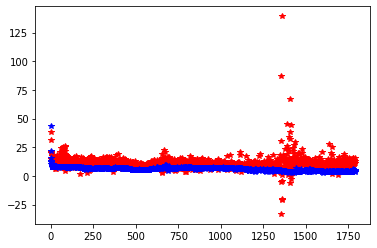

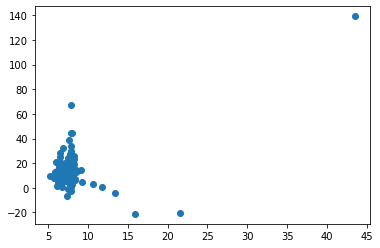

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


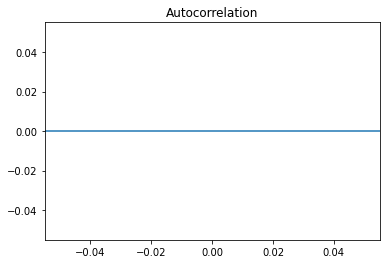

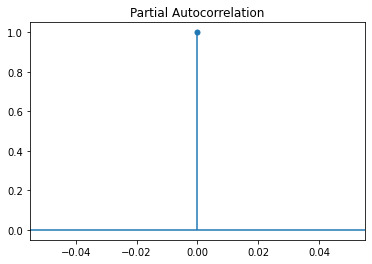

                                 OLS Regression Results                                
Dep. Variable:                GBP/mWh   R-squared (uncentered):                   0.758
Model:                            OLS   Adj. R-squared (uncentered):              0.758
Method:                 Least Squares   F-statistic:                              5612.
Date:                Thu, 29 Apr 2021   Prob (F-statistic):                        0.00
Time:                        22:18:15   Log-Likelihood:                         -5740.1
No. Observations:                1789   AIC:                                  1.148e+04
Df Residuals:                    1788   BIC:                                  1.149e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

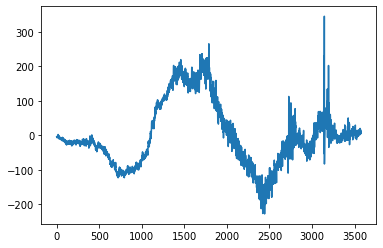

1357


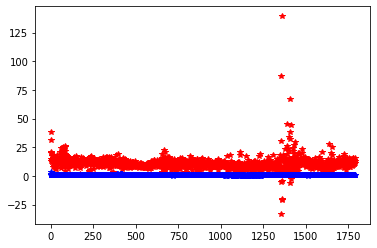

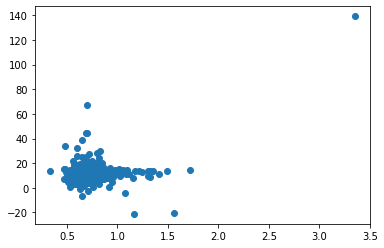

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


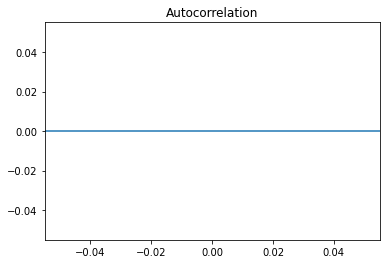

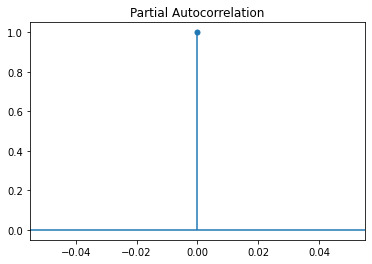

                                 OLS Regression Results                                
Dep. Variable:                GBP/mWh   R-squared (uncentered):                   0.762
Model:                            OLS   Adj. R-squared (uncentered):              0.762
Method:                 Least Squares   F-statistic:                              5715.
Date:                Thu, 29 Apr 2021   Prob (F-statistic):                        0.00
Time:                        22:18:16   Log-Likelihood:                         -5727.7
No. Observations:                1789   AIC:                                  1.146e+04
Df Residuals:                    1788   BIC:                                  1.146e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

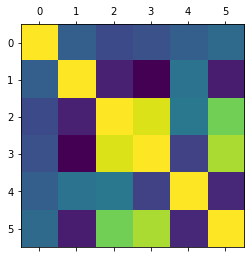

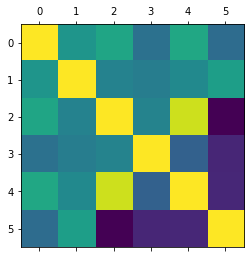

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                GBP/mWh   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     51.06
Date:                Thu, 29 Apr 2021   Prob (F-statistic):           4.78e-48
Time:                        22:18:16   Log-Likelihood:                -4389.1
No. Observations:                1199   AIC:                             8790.
Df Residuals:                    1193   BIC:                             8821.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.5160      3.159      2.379      0.018       1.318      13.714
temperature           0.1619      0.030      5.457      0.000       0.104       0.220
coal Price           -0.6092      0.073     -8.368      0.000      -0.752      -0.466
oil Price             0.2423      0.046      5.212      0.000       0.151       0.334
uranium Price         1.0814      0.104     10.377      0.000       0.877       1.286
natural gas Price     4.7122      0.633      7.442      0.000       3.470       5.954
==============================================================================
Omnibus:                      793.376   Durbin-Watson:                   0.386
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26768.054
Skew:                           2.548   Prob(JB):                         0.00
Kurtosis:                      25.579   Cond. No.                     1.50e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [187]:
from scipy import signal
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  #for plotting purpose
from sklearn import linear_model   #for implementing multiple linear regression
import statsmodels.api as sm
#corr = signal.correlate(sig_noise, np.ones(128), mode='same') / 128

set = Differenced_Set

Lagged_Differenced_Set = pd.DataFrame()
Lagged_Set = pd.DataFrame()
TrainO_Lagged_Set = pd.DataFrame()
lags = []

for f in range(1,len(set.columns)):
    #print(f)
    #print(len(futures01[f].result()))
        
    data_1 = set.iloc[:,0]
    data_2 = set.iloc[:,f]

    corr = np.correlate(data_1 - np.mean(data_1), 
                        data_2 - np.mean(data_2),
                        mode='full')
    plt.plot(corr)
    plt.show()
    lag = corr.argmax() - (len(data_1) - 1)
    print(lag)
    plt.plot(data_1, 'r*')
    plt.plot(data_2, 'b*')
    plt.show()

    plt.scatter(data_2.shift(lag),data_1)
    plt.show()
    
    plot_acf(data_2.shift(lag))
    plt.show()
    
    plot_pacf(data_2.shift(lag))
    plt.show()

    y = data_1
    X = data_2
    #reg = LinearRegression().fit(X, y)

    #print(reg.score(X, y),reg.coef_,reg.intercept_)

    model = sm.OLS(y,X)
    results = model.fit()
    print(results.summary())
    
    #Lagged_Differenced_Set = pd.concat([Lagged_Differenced_Set,data_2.shift(lag)],axis=1)
    TrainO_Lagged_Set = pd.concat([TrainO_Lagged_Set,trainOuter.iloc[:,f].shift(lag)],axis=1)
    Lagged_Set = pd.concat([Lagged_Set,all_data.iloc[:,f].shift(lag)],axis=1)
    lags.append(lag)
    
TrainO_Lagged_Set = pd.concat([trainOuter.iloc[:,0],TrainO_Lagged_Set],axis=1)
Lagged_Set = pd.concat([all_data.iloc[:,0],Lagged_Set],axis=1)
#Lagged_Differenced_Set = pd.concat([all_data.iloc[:,0],Lagged_Set],axis=1)
    
#Lagged_Differenced_Set = Lagged_Differenced_Set.dropna()    

Lagged_Set=Lagged_Set.dropna()

X=Lagged_Set.iloc[:,1:]
Y=Lagged_Set.iloc[:,0]
reg=LinearRegression()     #initiating linearregression
reg.fit(X,Y)
Intercept=reg.intercept_
Coefficients=reg.coef_

plt.matshow(Lagged_Set.corr())
plt.show()

plt.matshow(TrainO_Lagged_Set.corr())
plt.show()

X=sm.add_constant(X)        #to add constant value in the model
model= sm.OLS(Y,X).fit()         #fitting the model
predictions= model.summary()      #summary of the model
predictions



In [188]:
print(lags)
print(all_data.columns)

#choice = trainOuter
choice = Differenced_Set

for i in range(0,len(lags)):
    print(i)
    print(lags[i])
    print(pd.concat([choice.iloc[:,[0]],choice.iloc[:,[i]].shift(0)],axis=1).dropna().corr().values[0][1])
    print(pd.concat([choice.iloc[:,[0]],choice.iloc[:,[i]].shift(lags[i])],axis=1).dropna().corr().values[0][1])



[446, 1357, 1357, 1357, 1357]
Index(['GBP/mWh', 'temperature', 'coal Price', 'oil Price', 'uranium Price',
       'natural gas Price'],
      dtype='object')
0
446
1.0
-0.01599524892665351
1
1357
-0.0797286195040839
0.1579001000267831
2
1357
0.26180654836663675
0.5039507258951744
3
1357
0.17314537855640502
0.4880812284029308
4
1357
0.1214194387786695
0.5036561028951004


In [189]:
Lagged_Set.describe()

,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price
count,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000
mean,48.900255,54.496719,69.648331,82.861326,35.925865,3.408293
std,10.371931,10.065781,16.169155,28.795841,3.754354,0.866648
min,26.495000,25.803750,39.948750,27.937083,27.750000,1.640125
25%,41.223333,47.084167,54.930000,54.714792,34.500000,2.716000
50%,47.627917,54.485417,72.603750,100.820000,35.900000,3.561000
75%,54.665417,62.606042,84.030000,108.662083,38.034375,4.038271
max,170.150000,80.261667,99.610000,118.900000,44.000000,6.149000


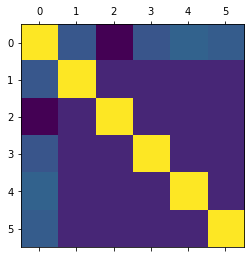

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                GBP/mWh   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     51.06
Date:                Thu, 29 Apr 2021   Prob (F-statistic):           4.78e-48
Time:                        22:18:34   Log-Likelihood:                -1585.1
No. Observations:                1199   AIC:                             3182.
Df Residuals:                    1193   BIC:                             3213.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.836e-16      0.026  -1.08e-14      1.000      -0.052       0.052
0              0.1842      0.026      7.007      0.000       0.133       0.236
1             -0.1195      0.026     -4.548      0.000      -0.171      -0.068
2              0.1741      0.026      6.624      0.000       0.123       0.226
3              0.2340      0.026      8.900      0.000       0.182       0.286
4              0.2077      0.026      7.901      0.000       0.156       0.259
==============================================================================
Omnibus:                      793.376   Durbin-Watson:                   0.386
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26768.054
Skew:                           2.548   Prob(JB):                         0.00
Kurtosis:                      25.579   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [190]:
#from zca import ZCA
trf = ZCA().fit(Lagged_Set.iloc[:,1:])
X_whitened = trf.transform(Lagged_Set.iloc[:,1:])
#X_reconstructed = trf.inverse_transform(X_whitened)
#assert(np.allclose(X, X_reconstructed)) # True
X=pd.DataFrame(X_whitened).set_index(Y.index)

Y=(Lagged_Set.iloc[:,0]-np.mean(Lagged_Set.iloc[:,0]))/np.std(Lagged_Set.iloc[:,0])
reg=LinearRegression()     #initiating linearregression
reg.fit(X,Y)
Intercept=reg.intercept_
Coefficients=reg.coef_

plt.matshow(pd.concat([Y,X],axis=1).corr())
plt.show()

X=sm.add_constant(X)        #to add constant value in the model
model= sm.OLS(Y,X).fit()         #fitting the model
smry= model.summary()      #summary of the model
smry


In [123]:
#data_zca.describe()
#data_zca.set_index(Lagged_Set.index)

In [193]:
n_steps = 21
n_ahead = 2
n_features = len(Lagged_Set.columns)

#X_train, Y_train, X_valid, Y_valid, X_test, asc = ts_train_test_normalize(all_data.resample('D').mean(),n_steps,n_ahead,n_features)
X_train, Y_train, X_valid, Y_valid, X_test, Y_test, asc, trf, std, mean = ts_train_test_normalize(Lagged_Set,n_steps,n_ahead,n_features)
print(X_train.shape[0],X_train.shape[1],X_train.shape[2])
print(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2])
print(X_valid.shape[0],X_valid.shape[1],X_valid.shape[2])
print(Y_valid.shape[0],Y_valid.shape[1],Y_valid.shape[2])
print(X_test.shape[0],X_test.shape[1],X_test.shape[2])

692 21 6
692 21 2
126 21 6
126 21 2
358 21 6


In [ ]:
'''
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8)

#tf.compat.v1.ConfigProto.set_random_seed(1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
'''

In [222]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import autokeras as ak

epochs_ = 100
batch_size_ = 25

np.random.seed(42)
tf.random.set_seed(42)

from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.optimizers import SGD

#simple RNN
data_ = Lagged_Set

model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(data_.columns)]),
    keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(data_.columns)]),
    keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(data_.columns)]),
    keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(data_.columns)]),
    #keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(data_.columns)]),
    #keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(data_.columns)]),
    keras.layers.SimpleRNN(64, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

model6.compile(loss="MAPE", optimizer="rmsprop",metrics=['MAPE'])
history = model6.fit(X_train, Y_train, epochs=epochs_,batch_size=batch_size_,validation_data=(X_valid, Y_valid))


Epoch 1/100
28/28 [==============================] - 4s 34ms/step - loss: 650.8524 - MAPE: 650.8525 - val_loss: 120.0767 - val_MAPE: 120.0767
Epoch 2/100
28/28 [==============================] - 0s 16ms/step - loss: 441.9006 - MAPE: 441.9006 - val_loss: 98.4496 - val_MAPE: 98.4496
Epoch 3/100
28/28 [==============================] - 0s 16ms/step - loss: 266.0845 - MAPE: 266.0845 - val_loss: 102.5106 - val_MAPE: 102.5106
Epoch 4/100
28/28 [==============================] - 0s 16ms/step - loss: 263.9976 - MAPE: 263.9976 - val_loss: 111.9315 - val_MAPE: 111.9315
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 238.0492 - MAPE: 238.0492 - val_loss: 97.2566 - val_MAPE: 97.2566
Epoch 6/100
28/28 [==============================] - 0s 16ms/step - loss: 201.7728 - MAPE: 201.7728 - val_loss: 100.6818 - val_MAPE: 100.6818
Epoch 7/100
28/28 [==============================] - 0s 16ms/step - loss: 180.7968 - MAPE: 180.7968 - val_loss: 97.0939 - val_MAPE: 97.0940
Epoch 8/100


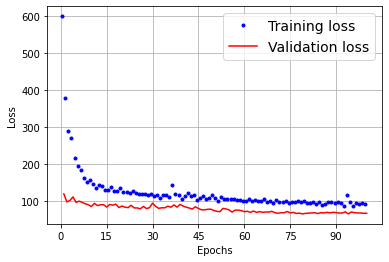

In [223]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [224]:
np.random.seed(42)
tf.random.set_seed(42)

#GRU with regularization
'''
model10 = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, len(all_data.columns)]),
    
    keras.layers.GRU(50, return_sequences=True,activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(50, return_sequences=True,activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(50, return_sequences=True,activation='tanh'),
    keras.layers.Dropout(0.2),

    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

#model10.compile(loss="mape", optimizer="adam")
model10.compile(tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False, name="SGD"),loss='MAPE')
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=epochs_,batch_size=batch_size_,
                    validation_data=(X_valid, Y_valid[:, 3::2]))#, callbacks = [es])

'''


'\nmodel10 = keras.models.Sequential([\n    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",\n                        input_shape=[None, len(all_data.columns)]),\n    \n    keras.layers.GRU(50, return_sequences=True,activation=\'tanh\'),\n    keras.layers.Dropout(0.2),\n    keras.layers.GRU(50, return_sequences=True,activation=\'tanh\'),\n    keras.layers.Dropout(0.2),\n    keras.layers.GRU(50, return_sequences=True,activation=\'tanh\'),\n    keras.layers.Dropout(0.2),\n\n    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))\n])\n\n#model10.compile(loss="mape", optimizer="adam")\nmodel10.compile(tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False, name="SGD"),loss=\'MAPE\')\nhistory2 = model10.fit(X_train, Y_train[:, 3::2], epochs=epochs_,batch_size=batch_size_,\n                    validation_data=(X_valid, Y_valid[:, 3::2]))#, callbacks = [es])\n\n'

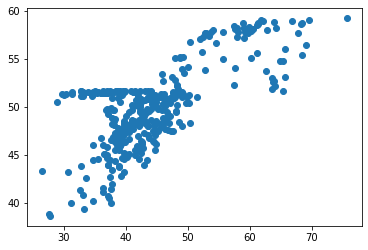

In [225]:
actual = return_actual(model6, asc, data_, X_test, trf, std, mean)

plt.scatter(actual["actual"],actual["predictions"])

In [226]:
from sklearn.metrics import mean_squared_error
rmse1 = mean_squared_error(actual["actual"], actual["predictions"], squared=True)
rmse2 = mean_squared_error(actual["actual"].shift(-1).dropna(), actual["predictions"][0:len(actual["actual"].shift(-1).dropna())], squared=True)
rmse1-rmse2

-5.707910937506156

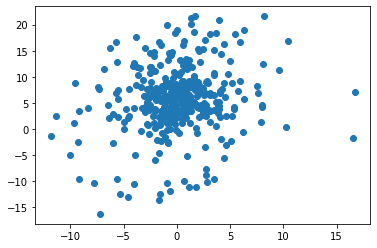

In [227]:
plt.scatter(actual["actual"].shift(1)-actual["actual"],actual["predictions"]-actual["actual"])


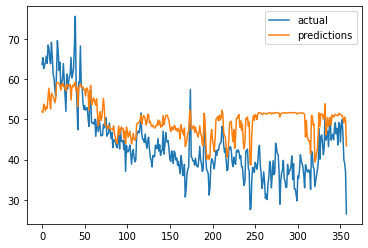

In [228]:
from matplotlib import pyplot as plt
plt.plot(actual["actual"],label="actual")
plt.plot(actual["predictions"],label="predictions")
plt.legend()
plt.show()